Main Imports

In [1]:
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import scvi

c:\Users\Caleb\anaconda3\envs\scanpy2\Lib\site-packages\scvi\_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
c:\Users\Caleb\anaconda3\envs\scanpy2\Lib\site-packages\scvi\_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
#Adata read / visualization 
adata = sc.read_h5ad('scvi-lifespanlabels.h5ad')
print(adata)


AnnData object with n_obs × n_vars = 72272 × 2010
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'percent_ribo', 'n_counts', 'IG_gene_percentage', 'sample', 'vaccine', 'batch', '_scvi_batch', '_scvi_labels', 'leiden', 'lifespan'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells-0', 'gene_biotype-0', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'n_cells-1', 'gene_biotype-1', 'n_cells_by_counts-10', 'mean_counts-10', 'pct_dropout_by_counts-10', 'total_counts-10', 'n_cells-10', 'gene_biotype-10', 'n_cells_by_counts-11', 'mean_counts-11', 'pct_dropout_by_counts-11', 'total_counts-11', 'n_cells-11', 'gene_biotype-11', 'n_cells_by_counts-12', 'mean_counts-12', 'pct_dropout_by_counts-12', 'total_counts-12', 'n_cells-12', 'gene_biotype-12', 'n_cells_by_counts-13', 'mean_counts-13', 'pct_dropout_by_counts-13', 'total_counts-13', 'n_ce

In [ ]:
#Condition assignment
# This was specific for my Vaccine work, but can be generalized
# If you want to label groups of obs as a greater condition, this is the formula for doing it
# Allow for easy comparison between these bulk groupings
short_lived_conditions = ['PVS-23', 'HEP-B'] 
long_lived_conditions = ['TDAP']  

adata.obs['lifespan'] = np.where(adata.obs['vaccine'].isin(short_lived_conditions), 'short_lived', 'long_lived')

print(adata.obs)

In [4]:
#Decoupler import for pseudobulk
import decoupler as dc

In [ ]:
#Loads data into the decoupler pseudobulk
#sample column is the sample identifier in the adata, groups_col is the clustering
#layer is the counts layer - make sure this has been preserved during previous processing and is not the log normalized counts that are used in the creation of UMAPs, etc.
#mode is the type of pseudobulking - options are sum, mean, and median
#min cells and min counts are self explanatory - it's a baseline filter for genes and cells to keep based on cells appeared in and gene counts within each cell
pdata = dc.get_pseudobulk(
    adata,
    sample_col='sample',
    groups_col='leiden',
    layer='counts',
    mode='sum',
    min_cells=10,
    min_counts=1000
)
print(pdata)

In [ ]:
#this is a random assignment version of the labelling from  above for the pdata object
#the assignment on the adata object will carry over to the pdata object
#but if you want to randomly assign the variables instead to confirm differential expression significance
# run this block here and directly manipulate the pdata object
short_lived_conditions = ['PVS-23', 'HEP-B']
long_lived_conditions = ['TDAP']
pdata.obs['lifespan'] = np.where(pdata.obs['vaccine'].isin(short_lived_conditions), 'short_lived', 'long_lived')

pdata.obs['lifespan'] = np.random.permutation(pdata.obs['lifespan'].values)
print(pdata.obs)

In [ ]:
#plots each cluster of each sample, visualizing gene counts and cell numbers
dc.plot_psbulk_samples(pdata, groupby=['sample', 'leiden'], figsize=(12, 4))
# Store raw counts in layers - doing what you should have done in your UMAP processing before normalizing and scaling data again
pdata.layers['counts'] = pdata.X.copy()

# Normalize, scale and compute pca on the data
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)

# Return raw counts to X in place of the normalized ones, plot the pca and variance ratio charts
dc.swap_layer(pdata, 'counts', X_layer_key=None, inplace=True)
sc.pl.pca(pdata, color=['sample', 'leiden'], ncols=1, size=300)
sc.pl.pca_variance_ratio(pdata)


#plots metadata associations between specified adata.obs, allows for visualiziation of correlation between conditions
dc.get_metadata_associations(
    pdata,
    obs_keys = ['sample', 'leiden', 'psbulk_n_cells', 'psbulk_counts', 'lifespan'],  # Metadata columns to associate to PCs
    obsm_key='X_pca',  # Where the PCs are stored
    uns_key='pca_anova',  # Where the results are stored
    inplace=True,
)
dc.plot_associations(
    pdata,
    uns_key='pca_anova',  # Summary statistics from the anova tests
    obsm_key='X_pca',  # where the PCs are stored
    stat_col='p_adj',  # Which summary statistic to plot
    obs_annotation_cols = ['lifespan', 'leiden', 'sample'], # which sample annotations to plot
    titles=['Principle component scores', 'Adjusted p-values from ANOVA'],
    figsize=(7, 5),
    n_factors=10,
)

In [9]:
#This is unfortunately a lazily hardcoded way of doing clusters - each individual variable is made from one cluster
#cluster numbers need to be adjusted based on the number of clusters in your dataset
#Candidate for code improvement, could be looped
clus0 = pdata[pdata.obs['leiden'] == '0'].copy()
clus1 = pdata[pdata.obs['leiden'] == '1'].copy()
clus2 = pdata[pdata.obs['leiden'] == '2'].copy()
clus3 = pdata[pdata.obs['leiden'] == '3'].copy()
clus4 = pdata[pdata.obs['leiden'] == '4'].copy()
clus5 = pdata[pdata.obs['leiden'] == '5'].copy()
clus6 = pdata[pdata.obs['leiden'] == '6'].copy()
clus7 = pdata[pdata.obs['leiden'] == '7'].copy()
clus8 = pdata[pdata.obs['leiden'] == '8'].copy()
clus9 = pdata[pdata.obs['leiden'] == '9'].copy()
num_clusters = 10

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))

axes = axes.flatten()

#plots the genes filtering by expression chart (visualization of where the cutoffs land)
#Then actually does that filtering
#should be split into two loops potentially, or all individual
for i in range(num_clusters):
    clus = eval(f'clus{i}')
    ax = axes[i]
    dc.plot_filter_by_expr(clus, group='lifespan', min_count=10, min_total_count=15, ax=ax)
    ax.set_title(f'clus{i}')
    genes = dc.filter_by_expr(clus, group='lifespan', min_count=10, min_total_count=15)
    clus = clus[:, genes].copy()
    clus

plt.tight_layout()
plt.show()



In [ ]:
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats
import matplotlib.pyplot as plt

inference = DefaultInference(n_cpus=8)
# Number of clusters
num_clusters = 10

# Create figures and grids of subplots for volcano plots, bar plots, and network plots
fig_volcano, axes_volcano = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
fig_bar, axes_bar = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
fig_progeny, axes_progeny = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))

# Flatten the axes arrays for easy indexing
axes_volcano = axes_volcano.flatten()
axes_bar = axes_bar.flatten()
axes_progeny = axes_progeny.flatten()

# Define the list of clusters
clusters = [clus0, clus1, clus2, clus3, clus4, clus5, clus6, clus7, clus8, clus9]

# Loop over each cluster, perform analysis, and plot
for i, clus in enumerate(clusters):
    # Perform the DESeq2 analysis
    dds = DeseqDataSet(
        adata=clus,
        design_factors='lifespan',
        ref_level=['lifespan', 'long-lived'],
        refit_cooks=True,
        inference=inference,
    )
    dds.deseq2()
    
    stat_res = DeseqStats(
        dds,
        contrast=["lifespan", 'short-lived', 'long-lived'],
        inference=inference,
    )
    stat_res.summary()
    results_df = stat_res.results_df
    
    # Plot volcano plot on the specified axis
    ax_volcano = axes_volcano[i]
    dc.plot_volcano_df(
        results_df,
        x='log2FoldChange',
        y='padj',
        top=20,
        figsize=(8, 4),
        ax=ax_volcano
    )
    ax_volcano.set_title(f'clus{i}')
    
    results_df.to_csv(f'clus{i}' + '_pseudobulk.csv')
    # Prepare the data for the bar plot
    mat = results_df[['stat']].T.rename(index={'stat': f'Clus {i}'})
    
    # Replace NaN values with 0
    mat.fillna(0, inplace=True)
    
    # Get the collectri network and run ULM
    collectri = dc.get_collectri(organism='human', split_complexes=False)
    tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri)
    
    # Plot bar plot on the specified axis
    ax_bar = axes_bar[i]
    dc.plot_barplot(
        acts=tf_acts,
        contrast=f'Clus {i}',
        top=25,
        vertical=True,
        figsize=(3, 6),
        ax=ax_bar
    )
    ax_bar.set_title(f'clus{i}')
    
    # Identify top 2 highest and lowest TF activities for the current cluster
    tf_acts_cluster = tf_acts.loc[f'Clus {i}']
    top_tfs = tf_acts_cluster.nlargest(2).index.tolist()
    bottom_tfs = tf_acts_cluster.nsmallest(2).index.tolist()
    n_sources = top_tfs + bottom_tfs
    
    # Plot network on the specified axis
    dc.plot_network(
        net=collectri,
        obs=mat,
        act=tf_acts,
        n_sources=n_sources,
        n_targets=15,
        node_size=100,
        figsize=(7, 7),
        c_pos_w='darkgreen',
        c_neg_w='darkred',
        vcenter=True,
    )
    plt.title(f'clus{i}' + 'Top Networks')
    progeny = dc.get_progeny(top=500)
    pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny)
    
    ax_progeny = axes_progeny[i]
    dc.plot_barplot(
        acts=pathway_acts,
        contrast=f'Clus {i}',
        top=25,
        vertical=False,
        figsize=(6, 3),
        ax=ax_progeny
    )
    ax_progeny.set_title(f'clus{i}')

# Adjust layout for all figures
fig_volcano.tight_layout()
fig_bar.tight_layout()
fig_progeny.tight_layout()


# Show the figures
plt.show()


In [ ]:
# adata = adata[adata.obs['leiden'].isin(['2','1'])]
print(adata)

In [ ]:
sc.pl.umap(adata, color="leiden", legend_loc='on data', title="SCVI umap")

In [ ]:

comparisons = [
    ('TDAP', 'HEP-B'),
    ('TDAP', 'PVS-23'),
    ('TDAP', ['HEP-B', 'PVS-23']),
    ('HEP-B', 'PVS-23')
]

# Function to perform differential expression analysis
def differential_expression(adata, group1, group2):
    if isinstance(group2, list):
        adata.obs['group'] = adata.obs['vaccine'].apply(lambda x: group1 if x == group1 else ('group2' if x in group2 else 'other'))
    else:
        adata.obs['group'] = adata.obs['vaccine'].apply(lambda x: group1 if x == group1 else (group2 if x == group2 else 'other'))
    
    adata_subset = adata[adata.obs['group'].isin([group1, 'group2' if isinstance(group2, list) else group2])]
    sc.tl.rank_genes_groups(adata_subset, 'group', method='wilcoxon', groups=[group1], reference='group2' if isinstance(group2, list) else group2)
    return adata_subset

# Function to create a volcano plot
def create_volcano_plot(adata, comparison, ax):
    group1, group2 = comparison
    de_results = adata.uns['rank_genes_groups']
    pvals = de_results['pvals'][group1]
    logfoldchanges = de_results['logfoldchanges'][group1]
    genes = adata.var_names
    
    # Filter results to include only genes present in adata.var_names
    filtered_indices = [i for i, gene in enumerate(de_results['names'][group1]) if gene in genes]
    filtered_genes = [de_results['names'][group1][i] for i in filtered_indices]
    filtered_logfoldchanges = [logfoldchanges[i] for i in filtered_indices]
    filtered_pvals = [pvals[i] for i in filtered_indices]
    
    # Ensure all arrays are of the same length
    if len(filtered_genes) == len(filtered_logfoldchanges) == len(filtered_pvals):
        df = pd.DataFrame({
            'gene': filtered_genes,
            'logfoldchange': filtered_logfoldchanges,
            'pval': filtered_pvals
        })
        df['-log10(pval)'] = -np.log10(df['pval'])
        
        # Export the differential expression results to a CSV file
        csv_filename = f"{group1}_vs_{group2}_differential_expression_all_cluster_bbknn.csv"
        df.to_csv(csv_filename, index=False)
        
        # Sort dataframe to find top 20 genes for both sides of the volcano plot
        top_upregulated = df.sort_values(by='logfoldchange', ascending=False).head(20)
        top_downregulated = df.sort_values(by='logfoldchange').head(20)
        
        # Plot all genes
        sns.scatterplot(data=df, x='logfoldchange', y='-log10(pval)', ax=ax, color='grey', alpha=0.5)
        
        # Highlight top 20 upregulated / downregulated genes
        sns.scatterplot(data=top_upregulated, x='logfoldchange', y='-log10(pval)', ax=ax, color='red', label='Upregulated in ' + group1)
        sns.scatterplot(data=top_downregulated, x='logfoldchange', y='-log10(pval)', ax=ax, color='blue', label='Downregulated in ' + group1)

        # Annotate top 20 genes
        for i, row in top_upregulated.iterrows():
            ax.text(row['logfoldchange'], row['-log10(pval)'], row['gene'], fontsize=8)
        for i, row in top_downregulated.iterrows():
            ax.text(row['logfoldchange'], row['-log10(pval)'], row['gene'], fontsize=8)
            
        ax.legend()
        ax.set_title(f'{group1} vs {group2}')
        ax.set_xlabel('Log Fold Change')
        ax.set_ylabel('-Log10(p-value)')
    else:
        print("Error: Arrays are not of the same length")

# Function to create a dot plot for the top 20 most differentially expressed genes
def create_dot_plot(adata, comparison, ax):
    group1, group2 = comparison
    de_results = adata.uns['rank_genes_groups']
    logfoldchanges = de_results['logfoldchanges'][group1]
    genes = adata.var_names
    
    # Filter results to include only genes present in adata.var_names
    filtered_indices = [i for i, gene in enumerate(de_results['names'][group1]) if gene in genes]
    filtered_genes = [de_results['names'][group1][i] for i in filtered_indices]
    filtered_logfoldchanges = [logfoldchanges[i] for i in filtered_indices]
    
    # Ensure all arrays are of the same length
    if len(filtered_genes) == len(filtered_logfoldchanges):
        df = pd.DataFrame({
            'gene': filtered_genes,
            'logfoldchange': filtered_logfoldchanges
        })
        
        # Sort dataframe to find top 20 genes for both sides of the volcano plot
        top_genes = df.sort_values(by='logfoldchange', ascending=False).head(20)['gene'].tolist() + \
                    df.sort_values(by='logfoldchange').head(20)['gene'].tolist()
        
        # Create dot plot for the top 20 most differentially expressed genes
        sc.pl.dotplot(adata, var_names=top_genes, groupby='vaccine', ax=ax, show=False)
        ax.set_title(f'{group1} vs {group2}')

# Create a grid of plots
fig, axes = plt.subplots(4, 2, figsize=(15, 20))

for i, comparison in enumerate(comparisons):
    adata_subset = differential_expression(adata, *comparison)
    create_volcano_plot(adata_subset, comparison, axes[i, 0])
    create_dot_plot(adata_subset, comparison, axes[i, 1])

plt.tight_layout()
plt.show()

In [ ]:

from matplotlib.backends.backend_pdf import PdfPages

# Perform the differential expression analysis for TDAP vs [PVS-23, HEP-B]
tdap_vs_pvs23_hepb = differential_expression(adata, 'TDAP', ['PVS-23', 'HEP-B'])

# Extract differential expression results
de_results = tdap_vs_pvs23_hepb.uns['rank_genes_groups']
group1 = 'TDAP'
logfoldchanges = de_results['logfoldchanges'][group1]
pvals = de_results['pvals'][group1]
genes = adata.var_names

# Filter results to include only genes present in adata.var_names
filtered_indices = [i for i, gene in enumerate(de_results['names'][group1]) if gene in genes]
filtered_genes = [de_results['names'][group1][i] for i in filtered_indices]
filtered_logfoldchanges = [logfoldchanges[i] for i in filtered_indices]
filtered_pvals = [pvals[i] for i in filtered_indices]

# Create dataframe for differential expression results
df = pd.DataFrame({
    'gene': filtered_genes,
    'logfoldchange': filtered_logfoldchanges,
    'pval': filtered_pvals
})
df['-log10(pval)'] = -np.log10(df['pval'])

# Get top 20 upregulated and downregulated genes
top_upregulated = df.sort_values(by='logfoldchange', ascending=False).head(20)
top_downregulated = df.sort_values(by='logfoldchange').head(20)
top_genes = pd.concat([top_upregulated, top_downregulated])['gene'].values

# Create PDF
with PdfPages('scvi_differential_expression_plots_2_3.pdf') as pdf:
    # Create UMAPs for top genes
    for gene in top_genes:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        for ax, vaccine in zip(axes, ['TDAP', 'PVS-23', 'HEP-B']):
            sc.pl.umap(adata[adata.obs['vaccine'] == vaccine], color=gene, show=False, ax=ax)
            ax.set_title(f'{gene} ({vaccine})', fontsize=8)
            ax.axis('off')
        pdf.savefig(fig)
        plt.close(fig)
    
    # Create violin and box plots for top genes
    for gene in top_genes:
        fig, axes = plt.subplots(2, 1, figsize=(5, 10))
        
        ax_violin = axes[0]
        ax_box = axes[1]
        
        sns.violinplot(x='vaccine', y=gene, data=adata.to_df().join(adata.obs), ax=ax_violin, palette='viridis')
        sns.boxplot(x='vaccine', y=gene, data=adata.to_df().join(adata.obs), ax=ax_box, palette='viridis')
        
        ax_violin.set_title(f'{gene} Violin', fontsize=8)
        ax_violin.set_xlabel('')
        ax_violin.set_ylabel('')
        ax_violin.tick_params(axis='x', labelsize=6)
        ax_violin.tick_params(axis='y', labelsize=6)
        
        ax_box.set_title(f'{gene} Box', fontsize=8)
        ax_box.set_xlabel('')
        ax_box.set_ylabel('')
        ax_box.tick_params(axis='x', labelsize=6)
        ax_box.tick_params(axis='y', labelsize=6)
        
        pdf.savefig(fig)
        plt.close(fig)


In [ ]:
comparisons = [
    ('TDAP', 'HEP-B'),
    ('TDAP', 'PVS-23'),
    ('TDAP', ['HEP-B', 'PVS-23']),
    ('HEP-B', 'PVS-23')
]

# Function to perform differential expression analysis
def differential_expression(adata, group1, group2):
    if isinstance(group2, list):
        adata.obs['group'] = adata.obs['vaccine'].apply(lambda x: group1 if x == group1 else ('group2' if x in group2 else 'other'))
    else:
        adata.obs['group'] = adata.obs['vaccine'].apply(lambda x: group1 if x == group1 else (group2 if x == group2 else 'other'))
    
    adata_subset = adata[adata.obs['group'].isin([group1, 'group2' if isinstance(group2, list) else group2])]
    sc.tl.rank_genes_groups(adata_subset, 'group', method='wilcoxon', groups=[group1], reference='group2' if isinstance(group2, list) else group2)
    return adata_subset

# Function to create a volcano plot
def create_volcano_plot(adata, comparison, ax):
    group1, group2 = comparison
    de_results = adata.uns['rank_genes_groups']
    pvals = de_results['pvals'][group1]
    logfoldchanges = de_results['logfoldchanges'][group1]
    genes = adata.var_names
    
    # Filter results to include only genes present in adata.var_names
    filtered_indices = [i for i, gene in enumerate(de_results['names'][group1]) if gene in genes]
    filtered_genes = [de_results['names'][group1][i] for i in filtered_indices]
    filtered_logfoldchanges = [logfoldchanges[i] for i in filtered_indices]
    filtered_pvals = [pvals[i] for i in filtered_indices]
    
    # Ensure all arrays are of the same length
    if len(filtered_genes) == len(filtered_logfoldchanges) == len(filtered_pvals):
        df = pd.DataFrame({
            'gene': filtered_genes,
            'logfoldchange': filtered_logfoldchanges,
            'pval': filtered_pvals
        })
        df['-log10(pval)'] = -np.log10(df['pval'])
        
        # Export the differential expression results to a CSV file
        csv_filename = f"{group1}_vs_{group2}_differential_expression_all_cluster_bbknn.csv"
        df.to_csv(csv_filename, index=False)
        
        # Sort dataframe to find top 20 genes for both sides of the volcano plot
        top_upregulated = df.sort_values(by='logfoldchange', ascending=False).head(20)
        top_downregulated = df.sort_values(by='logfoldchange').head(20)
        
        # Plot all genes
        sns.scatterplot(data=df, x='logfoldchange', y='-log10(pval)', ax=ax, color='grey', alpha=0.5)
        
        # Highlight top 20 upregulated / downregulated genes
        sns.scatterplot(data=top_upregulated, x='logfoldchange', y='-log10(pval)', ax=ax, color='red', label='Upregulated in ' + group1)
        sns.scatterplot(data=top_downregulated, x='logfoldchange', y='-log10(pval)', ax=ax, color='blue', label='Downregulated in ' + group1)

        # Annotate top 20 genes
        for i, row in top_upregulated.iterrows():
            ax.text(row['logfoldchange'], row['-log10(pval)'], row['gene'], fontsize=8)
        for i, row in top_downregulated.iterrows():
            ax.text(row['logfoldchange'], row['-log10(pval)'], row['gene'], fontsize=8)
            
        ax.legend()
        ax.set_title(f'{group1} vs {group2}')
        ax.set_xlabel('Log Fold Change')
        ax.set_ylabel('-Log10(p-value)')
    else:
        print("Error: Arrays are not of the same length")

# Create a grid of volcano plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for ax, comparison in zip(axes.flatten(), comparisons):
    adata_subset = differential_expression(adata, *comparison)
    create_volcano_plot(adata_subset, comparison, ax)

plt.tight_layout()
plt.show()


In [ ]:
adata = bbknnadata.copy()
# Extract relevant data from anndata
df = adata.to_df()
df['vaccine'] = adata.obs['vaccine']
df['cluster'] = adata.obs['leiden']  # Assuming 'cluster' is your clustering variable
df['n_genes_by_counts'] = adata.obs['n_genes_by_counts']
df['total_counts'] = adata.obs['total_counts']
df['pct_counts_mt'] = adata.obs['pct_counts_mt']
df['percent_ribo'] = adata.obs['percent_ribo']
# Variables to plot
variables = ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'percent_ribo']

# Number of clusters
n_clusters = df['cluster'].nunique()

clusters_order = sorted(df['cluster'].unique())

# Create a grid of subplots
fig, axes = plt.subplots(n_clusters, len(variables), figsize=(20, 4 * n_clusters))


# Plotting
for i, cluster in enumerate(clusters_order):
    cluster_data = df[df['cluster'] == cluster]
    for j, var in enumerate(variables):
        sns.violinplot(x='vaccine', y=var, data=cluster_data, palette=palette, ax=axes[i][j])
        if i == 0:
            axes[i][j].set_title(var)
        if j == 0:
            axes[i][j].set_ylabel(f'Cluster {cluster}')
        else:
            axes[i][j].set_ylabel('')
        axes[i][j].set_xlabel('')

plt.tight_layout()
plt.show()


In [ ]:


#performs principal coponent analysis and plots the variance ratio
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="sample")

#runs the model on the adata
model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")cc
model.train()

#adds the correction into the adata object
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

#runs neighbors using the correction as opposed to the standard PCA output
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)


sc.tl.umap(adata)

In [ ]:
sc.tl.leiden(adata, resolution= 4, key_added = "leiden")
sc.pl.umap(adata, color="leiden", legend_loc='on data', title="SCVI umap")

In [ ]:
bbknnadata.write_h5ad('bbknn-nob-nocontam-newcluster.h5ad')

In [ ]:
if 'neighbors' in adata.uns:
    del adata.uns['neighbors']
if 'X_umap' in adata.obsm:
    del adata.obsm['X_umap']
if 'X_scVI' in adata.obsm:
    del adata.obsm['X_scVI']    

sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
print(adata)

In [ ]:


n_rows = 4
n_cols = 4
sample_list = ['mcm209', 'mcm218', 'mcm229', 'mcm231', 'mcm241', 'mcm253', 'mcm254', 'mcm262', 'mcm267', 'mcm275', 'mcm276', 'mcm286', 'mcm289', 'mcm318', 'mcm323', 'mcm328']

# Ensure adata has a column for vaccine type
# adata.obs['vaccine_type'] should already exist and contain the vaccine type information

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

for i, sample in enumerate(sample_list):
    row = i // n_cols
    col = i % n_cols
    
    # Plot UMAP with all data in gray as background
    sc.pl.umap(adata, ax=axes[row, col], show=False)
    
    # Overlay the specific sample data colored by vaccine type
    adata_sample = adata[adata.obs['sample'] == sample]
    sc.pl.umap(adata_sample, color='vaccine', ax=axes[row, col], size = 4, show=False)
    
    axes[row, col].set_title(sample)

plt.tight_layout()
plt.show()


In [ ]:
bbknnadata = adata.copy()

#runs bbknn on the adata
sc.external.pp.bbknn(bbknnadata, batch_key='sample', n_pcs=30) 

# run umaps and clusters and on the integrated space
sc.tl.umap(bbknnadata)
#adjust resolution to match the cell above

In [ ]:
# sc.tl.leiden(bbknnadata, resolution= .75, key_added = "leiden")

#plots the umap colored by both cluster and sample
sc.pl.umap(bbknnadata, color="leiden", legend_loc='on data', title="BBKNN Corrected umap", show=False)
sc.pl.umap(bbknnadata, color="sample", title="BBKNN Corrected umap", show=False)
plt.show()

n_rows = 4
n_cols = 4
sample_list = ['mcm209', 'mcm218', "mcm229", "mcm231", "mcm241", "mcm253", "mcm254", "mcm262", "mcm267", "mcm275", "mcm276", "mcm286", "mcm289", "mcm318", "mcm323", "mcm328"]

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

for i, sample in enumerate(sample_list):
    row = i // n_cols
    col = i % n_cols
    sc.pl.umap(bbknnadata, color= 'sample', groups = [sample], ax=axes[row, col], show=False)
    axes[row, col].set_title(sample)

plt.tight_layout()

plt.show()
plt.show()
for vaccine in ['TDAP', 'PVS-23', 'HEP-B']:
    sc.pl.umap(bbknnadata, color = 'vaccine', groups = [vaccine])
sc.pl.umap(bbknnadata, color=['IG_gene_percentage'])

In [ ]:
n_rows = 4
n_cols = 4
# target_genes = ['RRM2', 'MS4A1', 'PAX5', 'BACH2']  
target_genes = ['BCL6', 'IRF8', 'ETS1', 'XBP1', 'PRDM1', 'IRF4', 'CD27', 'CD38', 'SDC1', 'IL6ST', 'IL6R', 'CD19', 'CD74', 'JCHAIN']  
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

for i, gene in enumerate(target_genes):
    row = i // n_cols
    col = i % n_cols
    sc.pl.umap(adata, color=gene, ax=axes[row, col], show=False)
    axes[row, col].set_title(gene)

plt.tight_layout()

plt.show()

In [ ]:
adata.obs['quality'] = ['high' if count > 2000 else 'low' for count in adata.obs['n_genes_by_counts']]

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(adata.obs[adata.obs['quality'] == 'low']['n_genes_by_counts'], bins=10, alpha=0.5, label='Low Quality (<2000 genes by counts)')
plt.hist(adata.obs[adata.obs['quality'] == 'high']['n_genes_by_counts'], bins=50, alpha=0.5, label='High Quality (>2000 genes by counts)')
plt.xlabel('Unique Gene Counts')
plt.ylabel('Number of Cells')
plt.title('Unique Gene Counts Distribution')
plt.legend()
plt.show()
sc.pl.umap(adata, color= 'quality', show=False)

In [ ]:
n_rows = 4
n_cols = 4
sample_list = ['mcm209', 'mcm218', "mcm229", "mcm231", "mcm241", "mcm253", "mcm254", "mcm262", "mcm267", "mcm275", "mcm276", "mcm286", "mcm289", "mcm318", "mcm323", "mcm328"]

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

for i, sample in enumerate(sample_list):
    row = i // n_cols
    col = i % n_cols
    sc.pl.umap(adata, color= 'sample', groups = [sample], ax=axes[row, col], show=False)
    axes[row, col].set_title(sample)

plt.tight_layout()

plt.show()

c:\Users\Caleb\anaconda3\envs\scanpy2\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\Caleb\anaconda3\envs\scanpy2\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
c:\Users\Caleb\anaconda3\envs\scanpy2\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


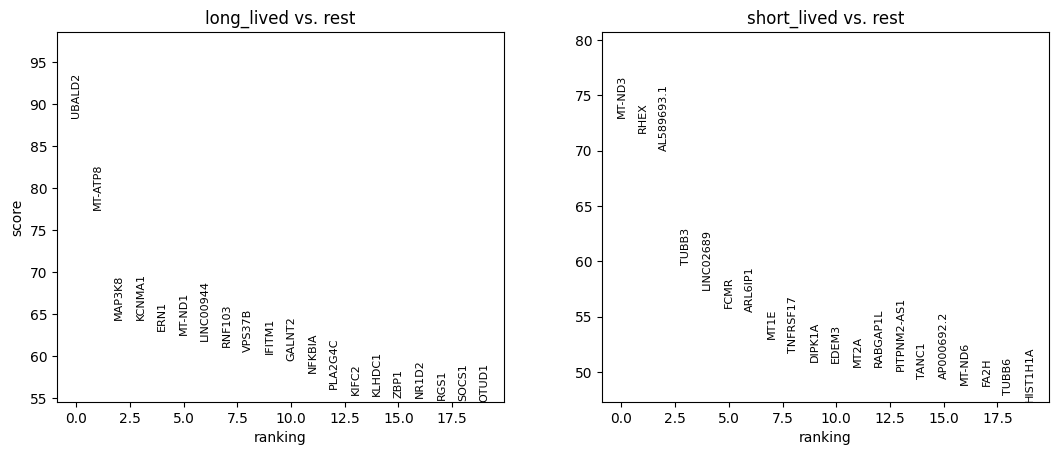

In [8]:
sample = '-SCVI-Lifespan-'
sc.tl.rank_genes_groups(adata, 'lifespan', use_raw=False, method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)
ranks = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(50)
ranks.to_csv('rank_genes_groups' + sample + '.csv')
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
scoresgroup = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals', 'scores', 'logfoldchanges']})
scoresgroup.to_csv('scores' + sample + '.csv')

In [ ]:
new_cluster_names = [
    'Plasma Cells', 'Erythroid', 'Langerhans (DC)', 'Plasma + MT', 'B Cells', 'Lymphocytes', 'Mixed Immune' ]
adata.rename_categories('leiden', new_cluster_names)
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False)


In [ ]:
for vaccine in ['TDAP', 'PVS-23', 'HEP-B']:
    sc.pl.umap(adata, color = 'vaccine', groups = [vaccine])
sc.pl.umap(adata, color=['IG_gene_percentage'])
sc.pl.umap(adata, color=['percent_ribo'])

In [ ]:
umap_colors = adata.uns['leiden_colors']
metrics = ['n_counts', 'n_genes_by_counts', 'IG_gene_percentage', 'pct_counts_mt', 'percent_ribo']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='leiden', y=metric, data=adata.obs, palette=umap_colors)
    plt.title(f'{metric} per cluster')
    plt.xlabel('Cluster')
    plt.ylabel(metric)
    plt.show()


In [ ]:
clusters = adata.obs['leiden'].unique()
samples = adata.obs['sample'].unique()

for cluster in clusters:
    cluster_data = adata.obs[adata.obs['leiden'] == cluster]
    sample_counts = cluster_data['sample'].value_counts()
    
    plt.figure(figsize=(8, 8))
    plt.pie(sample_counts, labels=sample_counts.index, autopct='%1.1f%%', colors=sns.color_palette('Set2', len(sample_counts)))
    plt.title(f'Cells per cluster {cluster} by sample')
    plt.show()

In [ ]:
vaccine_counts = adata.obs.groupby(['leiden', 'vaccine']).size().reset_index(name='count')
total_counts = adata.obs.groupby('leiden').size().reset_index(name='total_count')
vaccine_counts = vaccine_counts.merge(total_counts, on='leiden')
vaccine_counts['percentage'] = (vaccine_counts['count'] / vaccine_counts['total_count']) * 100


pivot_df = vaccine_counts.pivot(index='leiden', columns='vaccine', values='percentage').fillna(0)

# Plotting
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 8))

# Adding titles and labels
plt.title('Vaccine Percentage by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentage')
plt.legend(title='Vaccine', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Display the plot
plt.show()




In [ ]:
vaccine_counts = adata.obs.groupby(['leiden', 'vaccine']).size().reset_index(name='count')
total_counts = adata.obs.groupby('leiden').size().reset_index(name='total_count')
vaccine_counts = vaccine_counts.merge(total_counts, on='leiden')
vaccine_counts['percentage'] = (vaccine_counts['count'] / vaccine_counts['total_count']) * 100


pivot_df = vaccine_counts.pivot(index='leiden', columns='vaccine', values='count').fillna(0)

# Plotting
pivot_df.plot(kind='bar', stacked=True, figsize=(12, 8))

# Adding titles and labels
plt.title('Vaccine Count by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Vaccine', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Display the plot
plt.show()




In [ ]:

hep_b_data = adata.obs[adata.obs['vaccine'] == 'HEP-B']

sample_counts = hep_b_data.groupby(['leiden', 'sample']).size().reset_index(name='count')

hep_b_samples = hep_b_data['sample'].unique()
sample_counts = sample_counts[sample_counts['sample'].isin(hep_b_samples)]

pivot_df = sample_counts.pivot(index='leiden', columns='sample', values='count').fillna(0)

palette = sns.color_palette()
color_dict = dict(zip(hep_b_samples, palette))

ax = pivot_df.plot(kind='bar', stacked=True, figsize=(12, 8), color=[color_dict[col] for col in pivot_df.columns])

plt.title('Hep B Sample Counts by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')

handles, labels = ax.get_legend_handles_labels()
hep_b_labels = [label for label in labels if label in hep_b_samples]
ax.legend(handles, hep_b_labels, title='Sample ID', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

plt.show()




tdap_data = adata.obs[adata.obs['vaccine'] == 'TDAP']

sample_counts = tdap_data.groupby(['leiden', 'sample']).size().reset_index(name='count')

tdap_samples = tdap_data['sample'].unique()
sample_counts = sample_counts[sample_counts['sample'].isin(tdap_samples)]

pivot_df = sample_counts.pivot(index='leiden', columns='sample', values='count').fillna(0)

palette = sns.color_palette()
color_dict = dict(zip(tdap_samples, palette))



ax = pivot_df.plot(kind='bar', stacked=True, figsize=(12, 8), color=[color_dict[col] for col in pivot_df.columns])

plt.title('TDAP Sample Counts by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')

handles, labels = ax.get_legend_handles_labels()
tdap_labels = [label for label in labels if label in tdap_samples]
ax.legend(handles, tdap_labels, title='Sample ID', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

plt.show()

PVS23_data = adata.obs[adata.obs['vaccine'] == 'PVS-23']

sample_counts = PVS23_data.groupby(['leiden', 'sample']).size().reset_index(name='count')

PVS23_samples = PVS23_data['sample'].unique()
sample_counts = sample_counts[sample_counts['sample'].isin(PVS23_samples)]

pivot_df = sample_counts.pivot(index='leiden', columns='sample', values='count').fillna(0)

palette = sns.color_palette()
color_dict = dict(zip(PVS23_samples, palette))


ax = pivot_df.plot(kind='bar', stacked=True, figsize=(12, 8), color=[color_dict[col] for col in pivot_df.columns])

plt.title('PVS-23 Sample Counts by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')


handles, labels = ax.get_legend_handles_labels()
PVS23_labels = [label for label in labels if label in PVS23_samples]
ax.legend(handles, PVS23_labels, title='Sample ID', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

plt.show()